In [2]:
import os
import re
import shutil
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
import pandas as pd

In [2]:
filenames = """/media/GenomicResearch/MiSeq/Clostridium_perfringens/Profile/R21.2453.tsv
/media/GenomicResearch/MiSeq/Clostridium_perfringens/Profile/R21.2456.tsv
/media/GenomicResearch/MiSeq/Clostridium_perfringens/Profile/R21.2514.tsv
/media/GenomicResearch/MiSeq/Clostridium_perfringens/Profile/R21.2515.tsv
/media/Central_Lab_Storage/NcbiSRA/NCBI_Clostridium_perfringens_SRA/Profile/SRR7601230.tsv"""

In [3]:
profile = pd.concat((pd.read_csv(filename, sep='\t', header=0, names=[Path(filename).stem], index_col=0) for filename in filenames.split()), axis=1)

In [4]:
from src.tree import PairwiseDistanceMatrix, Dendrogram

In [5]:
distmatrix = PairwiseDistanceMatrix(profile)()

In [6]:
dendrogram = Dendrogram(distmatrix)
dendrogram(show_node_info=True)

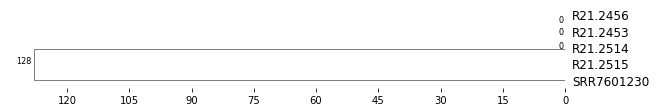

In [7]:
dendrogram.show_figure()

In [8]:
dendrogram.savefig('/media/GenomicResearch/MiSeq/Clostridium_perfringens/closest_strain.pdf')

In [ ]:
program = '/media/GenomicResearch/Tools/Easyfig/Easyfig.py'
identity = 90
min_length = 100
legend = 'top'
feature_type = 'CDS 255 204 135 arrow'
figure_width = 5000
output = '/home/chen1i6c04/easyfig.svg'
seq_1 = '/media/GenomicResearch/Issue/20211026_沙鹿童綜合Sal/Complete_genome/5A-sal-07_contig002.gbk'
seq_2 = '/home/chen1i6c04/5A-Sal-05_plasmid_cts.fasta'
# seq_3 = '/media/GenomicResearch/Issue/20211026_沙鹿童綜合Sal/Complete_genome/5A-sal-07_contig_002_294k.fa'

!python2 {program} \
-i {identity} -min_length {min_length} -blast_col_inv 255 0 0 0 0 255 -f1 T -f2 10000 -legend {legend} \
-f {feature_type} arrow -ann_height 50 -aln best -svg -uncomp T -width {figure_width} -blast_height 300 -o {output} \
{seq_1} {seq_2}

In [2]:
from Bio import SeqIO

In [8]:
filename = '/media/GenomicResearch/Issue/Benga/Listeria_monocytogenes.faa'

In [9]:
id_and_gene = [(record.description.split(None)) for record in SeqIO.parse(filename, 'fasta')]

In [10]:
namemap = {j: i for i, j in id_and_gene}

In [12]:
dirpath = Path('/home/chen1i6c04/data')
outpath = Path('/home/chen1i6c04/data_2')

for filename in dirpath.iterdir():
    df = pd.read_csv(filename, sep='\t', index_col=0)
    df.index = df.index.map(namemap)
    df = df.reindex(namemap.values())
    df.to_csv(outpath/filename.name, sep='\t')

In [7]:
filename

PosixPath('/home/chen1i6c04/data/SRR1269933.tsv')

In [13]:
dirpath = Path('/home/chen1i6c04/data2')
outpath = Path('/home/chen1i6c04/data3')

In [15]:
files = [i for i in dirpath.iterdir()]

In [45]:
for idx, i in enumerate(range(0, len(files), 500)):
    for j in files[i:i+500]:
        outdir = outpath/f"{idx}"
        outdir.mkdir(exist_ok=True)
        shutil.copy(j, outdir)

In [43]:
j

PosixPath('/home/chen1i6c04/data2/SRR3571296.tsv')

In [53]:
sample_names = ('R21.0464', 'R21.0535', 'R21.0754')

In [55]:
df = pd.read_csv(
    '/media/GenomicResearch/MiSeq/Salmonella_enterica/summaries.txt',
    sep='\t', usecols=['Key', 'amrfinder_result', 'resfinder_result', 'Point', 'ST', 'serovar', 'Inc type'],
    dtype=object
)

In [56]:
df = df[df['Key'].isin(sample_names)]

In [57]:
df.to_csv('/home/chen1i6c04/salmonella_enterica_summaries.tsv', sep='\t', index=False)

In [ ]:
from io import StringIO

In [ ]:
from Bio.Blast.Applications import NcbiblastxCommandline

In [ ]:
subject = '/home/chen1i6c04/ramAp.faa'

In [ ]:
query = '/media/MiSeqOutput/220121_M04855_0094_000000000-K424V/Assembly/R21-0754.fa'

In [ ]:
cline = NcbiblastxCommandline(query=query, subject=subject, outfmt='6 qseqid sseqid pident length slen')
stdout, stderr = cline()

In [ ]:
df = pd.read_csv(StringIO(stdout), sep='\t', names=['qseqid', 'sseqid', 'pident', 'length', 'slen'])

In [ ]:
df['cov'] = (df['length']/df['slen']*100).round(2)

In [ ]:
df[(df['pident']>=90)&(df['cov']>=60)]

,qseqid,sseqid,pident,length,slen,cov
165,NODE_15_length_100589_cov_14.209751_pilon,ramAp,92.105,114,114,100.0
409,NODE_47_length_6026_cov_15.867266_pilon,ramAp,100.000,114,114,100.0


In [58]:
import subprocess

In [59]:
dirpath = Path('/media/GenomicResearch/Issue/20201221_hybrid_and_denovo/Unicycler/Contigs')
outpath = Path('/media/GenomicResearch/Issue/20201221_hybrid_and_denovo/Unicycler/padloc')

In [60]:
for i in dirpath.iterdir():
    cmd = ['conda', 'run', '-n', 'padloc', 'padloc', '--fna', i, '--outdir', outpath, '--cpu', '4']
    subprocess.run(cmd)

In [102]:
results = []
for i in outpath.glob('*.csv'):
    sample_name = i.stem.split('.')[0]
    df = pd.read_csv(i, usecols=['seqid', 'start', 'end', 'system', 'protein.name'])
    df = df.groupby('system')['protein.name'].agg(lambda x: x.str.cat(sep=', '))
    df = pd.concat([df], keys=[sample_name], names=['sample_name',])
    results.append(df)

In [105]:
results = pd.concat(results).sort_index()

In [107]:
with pd.ExcelWriter('/media/GenomicResearch/Issue/20201221_hybrid_and_denovo/Unicycler/padloc.xlsx') as writer:
    results.to_excel(writer)

In [24]:
dirpaths = """/media/GenomicResearch/Issue/20210909_estimate_nanopore_depth/wga/20211007_WGA_barcode11_R18-1656
/media/GenomicResearch/Issue/20210909_estimate_nanopore_depth/wga/20211007_WGA_barcode12_R20-0088
/media/GenomicResearch/Issue/20210909_estimate_nanopore_depth/wga/20211018_WGA_barcode01_R18-1656
/media/GenomicResearch/Issue/20210909_estimate_nanopore_depth/wga/20211018_WGA_barcode02_R18-1656
/media/GenomicResearch/Issue/20210909_estimate_nanopore_depth/wga/20211028_WGA_barcode05_R18-1656
/media/GenomicResearch/Issue/20210909_estimate_nanopore_depth/wga/20211028_WGA_barcode06_R20-0088"""

In [22]:
for dirpath in dirpaths.splitlines():
    dirpath = Path(dirpath)
    outpath = dirpath/'reference'
    outpath.mkdir(exist_ok=True)
    shutil.copyfile(dirpath/'reference.fa', outpath/'contigs.fa')
    shutil.copyfile(dirpath/'reference.tsv', outpath/'profile.tsv')
    try:
        shutil.copyfile(dirpath/'reference.txt', outpath/'amrfinder.txt')
    except FileNotFoundError:
        pass
    try:
        shutil.copytree(dirpath/'resfinder-ref', outpath/'resfinder')
    except FileNotFoundError:
        pass

In [25]:
for dirpath in dirpaths.splitlines():
    dirpath = Path(dirpath)
    outpath = dirpath/'reference'
    classify_dirname = dirpath/'classify'
    if classify_dirname.exists():
        shutil.move(classify_dirname/'reference_kreport.txt', outpath/'centrifuge_kreport.txt')
        shutil.move(classify_dirname/'reference_report.txt', outpath/'kraken2_report.txt')